<a href="https://colab.research.google.com/github/juhumkwon/source_code/blob/main/VAE(10%EC%9B%94_7%EC%9D%BC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.4163 - val_loss: 0.3300
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.3212 - val_loss: 0.3132
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.3116 - val_loss: 0.3100
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.3052 - val_loss: 0.3040
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3024 - val_loss: 0.3016
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.2992 - val_loss: 0.2990
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2967 - val_loss: 0.2980
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2958 - val_loss: 0.3012
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2952 - val_loss: 0.2968
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.2931 - val_loss: 0.2947
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2924 - val_loss: 0.2944
Epoch 12/25
469/469 ━━━━━━━━━━━━━━━━━

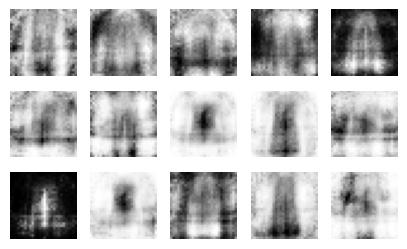

In [22]:
#출처: https://www.jeremyjordan.me/variational-autoencoders/

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# backend는 저수준의 연산을 다루기 위한 모듈
K = keras.backend

# 샘플링 층 정의 (μ와 γ로부터 샘플링)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mean))  # 랜덤 노이즈 샘플링
        return mean + K.exp(log_var / 2) * epsilon

# 인코더 생성
codings_size = 10
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# 디코더 생성
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)  # 28x28 크기의 이미지를 위해 sigmoidal 출력
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# VAE 모델 연결
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# 변이형 손실 정의
class VariationalLossLayer(keras.layers.Layer):
    def call(self, inputs):
        codings_mean, codings_log_var = inputs
        latent_loss = -0.5 * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1)
        self.add_loss(K.mean(latent_loss) / 784.)  # 이미지 크기를 나눠줌 (28*28=784)
        return inputs

# 손실 레이어 추가 및 모델 컴파일
loss_layer = VariationalLossLayer()
codings_mean, codings_log_var, codings = variational_encoder(inputs)
loss_layer([codings_mean, codings_log_var])
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# 모델 컴파일
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Fashion MNIST 데이터 로드
fashion_mnist = keras.datasets.fashion_mnist
(X_train, _), (X_valid, _) = fashion_mnist.load_data()

# 데이터 전처리 (0~1 범위로 정규화)
X_train = X_train.astype(np.float32) / 255.0
X_valid = X_valid.astype(np.float32) / 255.0

# VAE 훈련
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

# 이미지 생성 및 시각화
def plot_images(images, n_rows, n_cols):
    plt.figure(figsize=(n_cols, n_rows))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i], cmap="binary")
        plt.axis("off")
    plt.show()

# 새로운 코딩 생성 및 이미지 복원
n_images = 15  # 생성할 이미지 수
codings = tf.random.normal(shape=[n_images, codings_size])  # 잠재 공간에서 무작위로 샘플링
generated_images = variational_decoder(codings).numpy()

# 이미지 출력
plot_images(generated_images, n_rows=3, n_cols=5)  # 3행 5열의 이미지 출력
